Lecture notes

- SVM is for classification

1. Maximal Margin Classifier
- hyperplane: f(X)=0
- separating hyperplane: yi*f(Xi)>0 where yi={1,-1}
- maximal margin hyperplane (optimal separating hyperplan): the separating hyperplane farthest from the obsevations
- construction: find M, such tha the constrains ensure each observation is on the correct side and at least a distance M
- support vectors: observations lying directly on the bounday of the margin

2. Support Vector Classifier
- for non-separable case
- soft margin can be violated by some observations
- construction: similar to maximal margin hyperplane
    - use a tuning parameter controling slack variables, which plays as a budget for the violation
- support vectors: observations lying on the margin or the wrong side of the margin
- SVC decision rule is based only on support vectors, meaning it is very robust to the observations far from the hyperplane

3. Support Vector Machine
- enlarge or transform feature space to accommodate a non-linear boundary between classes
- rewrite the minimizing problem in a Loss+Penalty form and consider its Lagrangian dual problem
    - Loss term in SVM is called hinge loss
- generalize by using kernel k(xi,xj) to replace the inner product (xi,xj) in the dual problem
- SVM has the form f(x)=b+sum(cj*k(x,xj)), where cj is nonzero only for support vectors xj among all n observations
- SVM with more than two classes
    - One-versus-one (all-pairs): construct SVMs for all pairs of the classes, assign the test observation to the class to which it's most frequently assigned in these SVMs
    - One-versus-all: construct a SVM for one class (coded as +1) and all other classes (coded as -1), assign the test observation to the class for which its SVM value is largest
- Note: kernels can be used in other classification methods like logistic regression
- Note: SVM can be extended to regression problem, which is called support vector regression

Reference: SVM on wiki https://en.wikipedia.org/wiki/Support_vector_machine

In [87]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score

%matplotlib inline

In [43]:
# function to plot SVM results
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

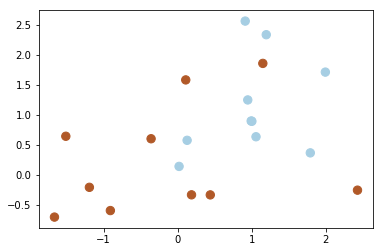

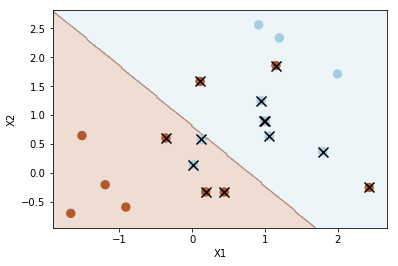

Number of support vectors:  13
{'C': 0.001}
[[ 2  6]
 [ 0 12]]


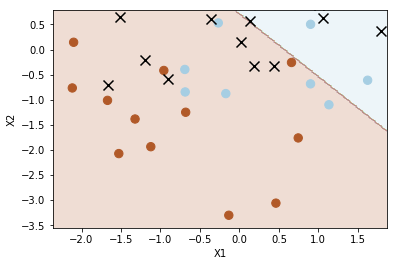

Number of support vectors:  20


In [94]:
# SVM - linear

# Generate data
# train data
np.random.seed(5)
X = np.random.randn(20,2)
y = np.repeat([1,-1], 10)
X[y == -1] = X[y == -1]+1
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
# test data
np.random.seed(1)
X_test = np.random.randn(20,2)
y_test = np.random.choice([-1,1], 20)
X_test[y_test == 1] = X_test[y_test == 1]-1
# Fit
svc = SVC(C=1,kernel='linear').fit(X,y)
plt.figure()
plot_svc(svc,X,y)
# GridSearchCV for best C
c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
est = GridSearchCV(SVC(kernel='linear'), dict(C=c), cv=10, scoring='accuracy').fit(X,y)
print(est.best_params_)
print(confusion_matrix(y_test,est.predict(X_test)))
plt.figure()
plot_svc(est.best_estimator_,X_test,y_test)

/home/cloudera/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


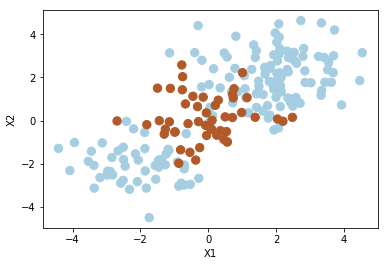

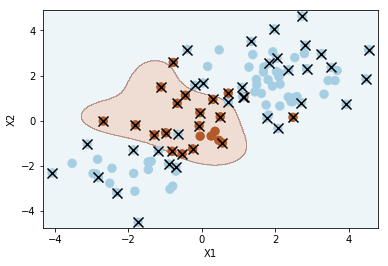

Number of support vectors:  51
{'C': 1, 'gamma': 0.5}
[[67  6]
 [ 9 18]]


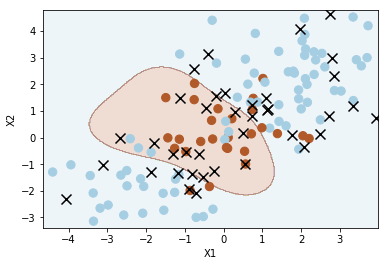

Number of support vectors:  41


In [92]:
# SVM - non-linear

# Generate data
np.random.seed(8)
X = np.random.randn(200,2)
X[:100] = X[:100] +2
X[101:150] = X[101:150] -2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=2)
plt.figure()
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

# Fit
svm = SVC(C=1,kernel='rbf',gamma=1).fit(X_train,y_train)
plt.figure()
plot_svc(svm,X_train,y_train)

# GridSearchCV for best C and gamma
c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
g = [0.5, 1,2,3,4]
est = GridSearchCV(SVC(kernel='rbf'), dict(C=c,gamma=g), cv=10, scoring='accuracy').fit(X_train,y_train)
print(est.best_params_)
print(confusion_matrix(y_test,est.predict(X_test)))
plt.figure()
plot_svc(est.best_estimator_,X_test,y_test)

/home/cloudera/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


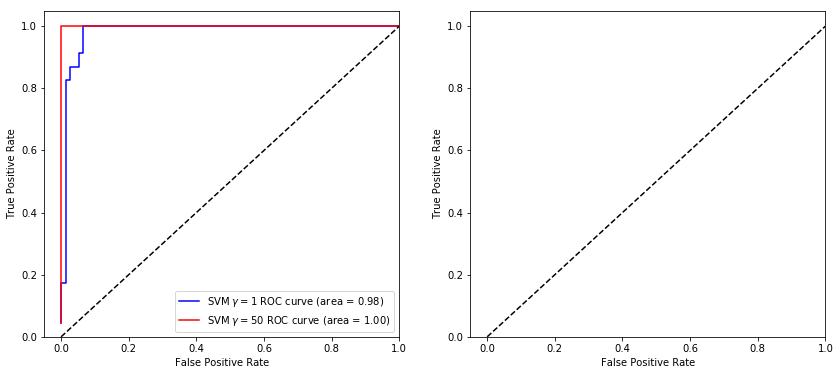

In [90]:
# Roc

# More constrained model
svm3 = SVC(C=1, kernel='rbf', gamma=1)
svm3.fit(X_train, y_train)
# More flexible model
svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = roc_auc_score(y_train, y_train_score3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = roc_auc_score(y_train, y_train_score4)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")